In [60]:
import csv
import pandas as pd
import numpy as np
#import filters  # THIS LIBRARY IS NOT INCLUDED IN THE REPOSITORY
import matplotlib.pyplot as pyp
import scipy.signal as signal
import numpy.fft as fft
import os         # ADD THIS SO WE CAN USE ENVIRONMENT VARIABLES
import matplotlib
from scipy.optimize import curve_fit
%matplotlib inline

#print os.environ
print os.environ.get('TAU_ACC_ZHAIRES_DIR')
#print os.environ['TAU_ACC_ZHAIRES_DIR']

/Users/wissels/Dropbox/MountainTop/harms_sims/npz_files/


In [18]:
pastel_colors = ['#FF6666','#FFCC66','#CCFF66','#66FF66','#66FFCC','#66FFFF','#66CCFF','#6666FF','#CC66FF','#FF66FF','#FF6FCF']
bright_colors = ['#FF0000','#FF8000','#FFFF00','#80FF00','#00FF00','#00FF80','#00FFFF','#0080FF','#0000FF','#8000FF','#FF00FF']
bright_colors2 = bright_colors = ['#FF0000','#FF8000','#80FF00','#00FF80','#0080FF','#0000FF','#8000FF','#FF00FF','#FF0080']
pyp.rcParams['font.size']=18
pyp.rcParams['legend.labelspacing'] = 0.1

In [2]:
#### Should move this to a library

In [3]:
def temp(f_MHz):
    # Dulk 2001
    nu = f_MHz # Hz
    tau = 5.0 * pow(nu, -2.1)
    Ieg = 1.0610e-20
    Ig  = 2.48e-20
    # Iv in  W/m^2/Hz/sr
    Iv = Ig * pow(nu, -0.52) * (1-np.exp(-tau))/tau + Ieg * pow(nu, -0.80) * np.exp(-tau)
    
    kB = 1.38064852e-23 # Watts / Hz / K
    c = 299792458 # m/s
    temp = Iv * c**2 / (2*(nu*1e6)**2)/kB

    return Iv, temp # W/m^2/Hz/sr, K

def read_npz_files(antenna_height, zenith):
    npzfile = np.load(os.environ['TAU_ACC_ZHAIRES_DIR'] + "/" + "altitude_%dkm_zenith_%d.npz"%(antenna_height, zenith))
    efield_td = npzfile['efield_td'][()] ## for some reason just reading the arrays gives a 0-dim array, so skip this.
    efield_fd = npzfile['efield_fd'][()]
    return efield_td, efield_fd

In [83]:
# WANT TO PARAMETERIZE THE EFIELDS AT ALL ZENITH ANGLES 
# FOLLOWING TECHNIQUE USED FOR ANITA
# WE WILL HAVE TO CHOOSE A FEW BANDS OF INTEREST BASED ON
# RESULTS FROM EFIELD_PULSES_ANGULAR_ACCEPTANCE
# this is for E=1.e17

def band_peak_efield(efield, freq, f_LO, bandwidth):
    df = freq[1]-freq[0]
    cut = np.logical_and(freq>=f_LO, freq<=f_LO + bandwidth)
    return np.sum(np.abs(efield[cut]))*df

def efield_vs_angle(h, z, f_Lo_list, bandwidth_list):

    off_angle_array = np.arange(0.1,4.0, 0.1)
    i_off_angle_array = range(1, len(off_angle_array)+1)
    epeak_list = np.zeros((len(f_Lo_list), len(bandwidth_list), len(i_off_angle_array)))
    cc = 0
    for i_offangle in i_off_angle_array:
        #if(i_offangle%10==0): print i_offangle
        offangle = off_angle_array[i_offangle-1]
        efield_td, efield_fd = read_npz_files(h,z)
        efield = efield_td[i_offangle]['y_v_per_m']
        time = efield_td[i_offangle]['time_s']
        time -= time[0]
        dt = time[1]-time[0]
        E_fft = np.fft.rfft(efield)*dt*1.e6 # use dt in µs so that fft is in units of V/m/MHz
        fr = np.fft.rfftfreq(len(efield), dt*1.e6) # frequencies in MHz
        for i_f_Lo in range(0,len(f_Lo_list)):
            f_Lo = f_Lo_list[i_f_Lo]
            for i_bandwidth in range(0,len(bandwidth_list)):
                bandwidth = bandwidth_list[i_bandwidth]
                epeak_list[i_f_Lo, i_bandwidth, cc] = band_peak_efield(E_fft, fr, f_Lo, bandwidth)
        cc+=1
    #pyp.figure(3)
    #pyp.plot(off_angle_array, voltage_SNR, 'ko')
    return off_angle_array, epeak_list

39 15


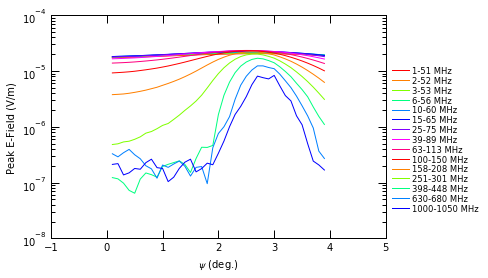

In [84]:
h = 2
z = 85
f_Lo_list = 10**np.arange(0.2,3.2,0.2)
bandwidth_list = np.array([50])
psi, epeak_list = efield_vs_angle(h, z, f_Lo_list, bandwidth_list)
print len(off_angle_array), len(epeak_list)

for i_f_Lo in range(0,len(f_Lo_list)):
    f_Lo = f_Lo_list[i_f_Lo]
    for i_bandwidth in range(0,len(bandwidth_list)):
        bandwidth = bandwidth_list[i_bandwidth]
        pyp.semilogy(psi, epeak_list[i_f_Lo, i_bandwidth,:], 
                     bright_colors2[i_f_Lo%9], label="%d-%d MHz"%(int(f_Lo), int(f_Lo) + int(bandwidth)))

pyp.xlabel("$\psi$ (deg.)")        
pyp.ylabel("Peak E-Field (V/m)")
pyp.legend(loc=[1.01, 0.1])

39 1


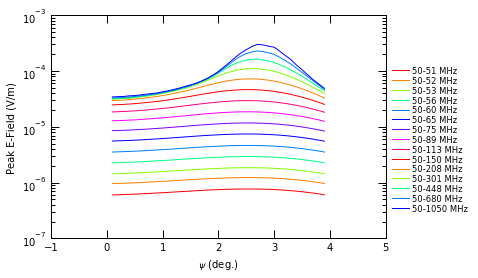

In [85]:
f_Lo_list = np.array([50])
bandwidth_list = 10**np.arange(0.2,3.2,0.2)
psi, epeak_list = efield_vs_angle(h, z, f_Lo_list, bandwidth_list)
print len(off_angle_array), len(epeak_list)

for i_f_Lo in range(0,len(f_Lo_list)):
    f_Lo = f_Lo_list[i_f_Lo]
    for i_bandwidth in range(0,len(bandwidth_list)):
        bandwidth = bandwidth_list[i_bandwidth]
        pyp.semilogy(psi, epeak_list[i_f_Lo, i_bandwidth,:], 
                     bright_colors2[i_bandwidth%9], label="%d-%d MHz"%(int(f_Lo), int(f_Lo) + int(bandwidth)))

pyp.xlabel("$\psi$ (deg.)")        
pyp.ylabel("Peak E-Field (V/m)")
pyp.legend(loc=[1.01, 0.1])

39 1


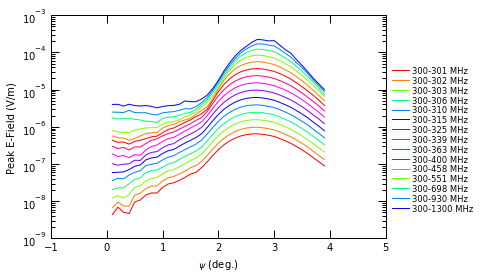

In [86]:
f_Lo_list = np.array([300])
bandwidth_list = 10**np.arange(0.2,3.2,0.2)
psi, epeak_list = efield_vs_angle(h, z, f_Lo_list, bandwidth_list)
print len(off_angle_array), len(epeak_list)

for i_f_Lo in range(0,len(f_Lo_list)):
    f_Lo = f_Lo_list[i_f_Lo]
    for i_bandwidth in range(0,len(bandwidth_list)):
        bandwidth = bandwidth_list[i_bandwidth]
        pyp.semilogy(psi, epeak_list[i_f_Lo, i_bandwidth,:], 
                     bright_colors2[i_bandwidth%9], label="%d-%d MHz"%(int(f_Lo), int(f_Lo) + int(bandwidth)))

pyp.xlabel("$\psi$ (deg.)")        
pyp.ylabel("Peak E-Field (V/m)")
pyp.legend(loc=[1.01, 0.1])

39 1


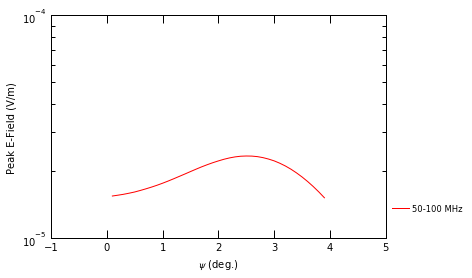

In [87]:
f_Lo_list = np.array([50])
bandwidth_list = np.array([50])
psi, epeak_list = efield_vs_angle(h, z, f_Lo_list, bandwidth_list)
print len(off_angle_array), len(epeak_list)

for i_f_Lo in range(0,len(f_Lo_list)):
    f_Lo = f_Lo_list[i_f_Lo]
    for i_bandwidth in range(0,len(bandwidth_list)):
        bandwidth = bandwidth_list[i_bandwidth]
        pyp.semilogy(psi, epeak_list[i_f_Lo, i_bandwidth,:], 
                     bright_colors2[i_bandwidth%9], label="%d-%d MHz"%(int(f_Lo), int(f_Lo) + int(bandwidth)))

pyp.xlabel("$\psi$ (deg.)")        
pyp.ylabel("Peak E-Field (V/m)")
pyp.legend(loc=[1.01, 0.1])



In [88]:
def airshower_beam_func(psi, E_0, frac_gauss, gauss_peak, gauss_width, E_1, width2):
    v = (psi - gauss_peak) / gauss_width
    E_field = E_0*(frac_gauss*np.exp(-v**2/2.) \
                   + (1-frac_gauss)/(1+v**2)) \
                   + E_1*np.exp(-psi**2/2./width2**2)
    return E_field

(0, 0.00025000000000000001)

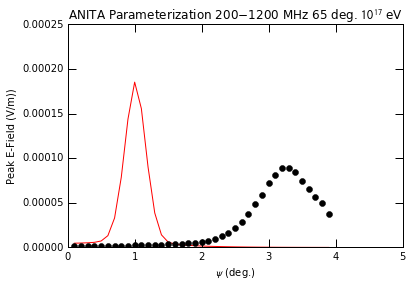

In [118]:
E_0  = 0.183*1.e-3     # V/m at ground level for 10^17 eV tau lepton.
gauss_peak = 1.01 # degrees
gauss_width = 0.160          # degrees
E_1 = 0.00385*1.e-3    # V/m at ground level for 10^17 eV tau lepton.
width2 = 1.14          # degrees
frac_gauss = 0.825 # fraction of Gaussian peak ( 1-frac_gauss is lorentzian)

test = airshower_beam_func(psi, E_0, frac_gauss, gauss_peak, gauss_width, E_1, width2)

h=37
z=60
f_Lo_list = np.array([200])
bandwidth_list = np.array([1000])
psi, epeak_list = efield_vs_angle(h, z, f_Lo_list, bandwidth_list)

pyp.plot(psi, test, 'r')
pyp.plot(psi, epeak_list[0,0,:], 'ko')
pyp.title("ANITA Parameterization 200-1200 MHz 65 deg. $10^{17}$ eV", fontsize=12)
pyp.ylabel("Peak E-Field (V/m))")
pyp.xlabel("$\psi$ (deg.)")
pyp.xlim(0)
pyp.ylim(0)

INITIAL PARAMETERS: 
_____________________
[0.000183, 0.825, 3.2000000000000002, 0.16, 3.85e-06, 1.14]
_____________________
FIT PARAMETERS: 
_____________________
[  8.78476721e-05   6.17100712e-01   3.28514300e+00   4.64037133e-01
   1.09597522e-06  -7.02164562e+03]
_____________________
1.79359703186e-06
8.89322341301e-05


(1.7649332997508983e-06, 0.0001)

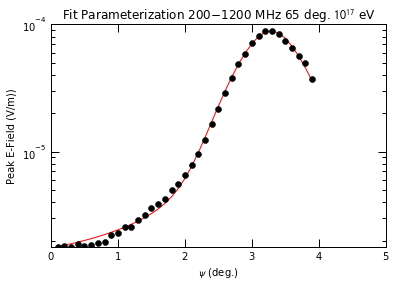

In [122]:
# Use ANITA parameterization to test the curve fit. 
# NOTE: SHIFTING FROM 1.01 deg to peak in the efield.
# Fit fails if initial parameter for gauss_peak is not close

E_0  = 0.183*1.e-3     # V/m at ground level for 10^17 eV tau lepton.
gauss_peak = psi[np.where(max(epeak_list[0][0]) == epeak_list[0][0][:])[0][0]]      # degree. 
gauss_width = 0.160          # degrees
E_1 = 0.00385*1.e-3    # V/m at ground level for 10^17 eV tau lepton.
width2 = 1.14          # degrees
frac_gauss = 0.825 # fraction of Gaussian peak ( 1-frac_gauss is lorentzian)
p0 = [E_0, frac_gauss, gauss_peak, gauss_width, E_1, width2] # initial parameters for the curve fit.

print "INITIAL PARAMETERS: "
print "_____________________"
print p0
print "_____________________"

h=37
z=60
f_Lo_list = np.array([200])
bandwidth_list = np.array([1000])
psi, epeak_list = efield_vs_angle(h, z, f_Lo_list, bandwidth_list)
popt, pcov = curve_fit(airshower_beam_func, psi, epeak_list[0,0,:], p0=p0)
print "FIT PARAMETERS: "
print "_____________________"
print popt
print "_____________________"

print epeak_list[0,0,0]
print max(epeak_list[0,0,:])
pyp.semilogy(psi, airshower_beam_func(psi, *popt), 'r')
pyp.plot(psi, epeak_list[0,0,:], 'ko')
pyp.title("Fit Parameterization 200-1200 MHz 65 deg. $10^{17}$ eV", fontsize=12)
pyp.ylabel("Peak E-Field (V/m))")
pyp.xlabel("$\psi$ (deg.)")
pyp.xlim(0)
pyp.ylim(0)

 39 15


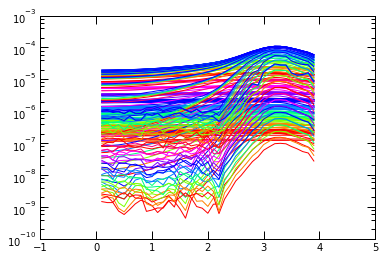

In [124]:
# Loading the files and calculating the peak e-fields are slow, so do it once
f_Lo_list = 10**np.arange(0.2,3.2,0.2)
bandwidth_list = 10**np.arange(0.2,3.2,0.2)
psi, epeak_list = efield_vs_angle(h, z, f_Lo_list, bandwidth_list)
print len(off_angle_array), len(epeak_list)

for i_f_Lo in range(0,len(f_Lo_list)):
    f_Lo = f_Lo_list[i_f_Lo]
    for i_bandwidth in range(0,len(bandwidth_list)):
        bandwidth = bandwidth_list[i_bandwidth]
        pyp.semilogy(psi, epeak_list[i_f_Lo, i_bandwidth,:], bright_colors2[i_bandwidth%9])

Starting frequency :  25.1188643151
INITIAL PARAMETERS: 
_____________________
[2.54504749271676e-07, -0.59047266039223589, 3.0000000000000004, 0.73171264457164342, 2.3426265031751317e-07, 359911350.43572414]
_____________________
FIT PARAMETERS: 
_____________________
[  1.35647976e-08  -4.57059394e-01   2.99740509e+00   7.36245594e-01
   2.41155391e-07   3.59911350e+08]
_____________________
INITIAL PARAMETERS: 
_____________________
[9.7393288532565799e-07, -0.45705939389501549, 3.0000000000000004, 0.73624559432089642, 8.9248816928010246e-07, 359911350.43572414]
_____________________
FIT PARAMETERS: 
_____________________
[  7.79503011e-08  -4.61435883e-01   2.99539146e+00   7.91384379e-01
   8.92154626e-07   3.59911350e+08]
_____________________
INITIAL PARAMETERS: 
_____________________
[3.9484902247566669e-06, -0.46143588308390715, 2.9000000000000004, 0.79138437854847843, 3.5126779454789825e-06, 359911350.43572414]
_____________________
FIT PARAMETERS: 
_____________________
[  2

(2.3426265031751317e-07, 0.0001)

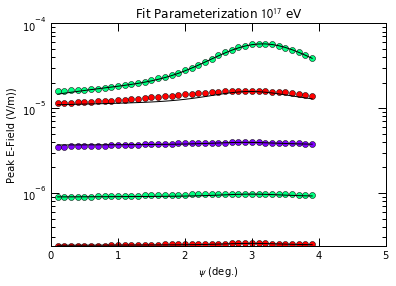

In [128]:
# Fit curves using a starting frequency of 25 MHz and varying the bandwidth.
# Using the initial parameters from the ANITA curve fit above 
# BUT finding the peak for each curve.
# NOTE: SHIFTING FROM 1.01 deg to peak in the efield.
# Fit fails if initial parameter for gauss_peak is not close
i_f_Lo  = 6
print "Starting frequency : ", f_Lo_list[i_f_Lo]

for i_bandwidth in range(0,len(bandwidth_list),3):
    bandwidth = bandwidth_list[i_bandwidth]
    E_0  =  max(epeak_list[i_f_Lo][i_bandwidth])# V/m at ground level for 10^17 eV tau lepton.
    frac_gauss = popt[1] # fraction of Gaussian peak ( 1-frac_gauss is lorentzian)
    gauss_peak = psi[np.where(max(epeak_list[i_f_Lo][i_bandwidth]) == epeak_list[i_f_Lo][i_bandwidth][:])[0][0]]      # degree. 
    gauss_width = popt[3]         # degrees
    E_1 = epeak_list[i_f_Lo][i_bandwidth][0]   # V/m at ground level for 10^17 eV tau lepton.
    width2 = popt[5]         # degrees
    p0 = [E_0, frac_gauss, gauss_peak, gauss_width, E_1, width2] # initial parameters for the curve fit.
    print "INITIAL PARAMETERS: "
    print "_____________________"
    print p0
    print "_____________________"
    popt, pcov = curve_fit(airshower_beam_func, psi, epeak_list[i_f_Lo,i_bandwidth,:], p0=p0)
    pyp.semilogy(psi, epeak_list[i_f_Lo, i_bandwidth,:], 'o', color = bright_colors2[i_bandwidth%9])
    pyp.semilogy(psi, airshower_beam_func(psi, *popt), 'k')
    print "FIT PARAMETERS: "
    print "_____________________"
    print popt
    print "_____________________"
pyp.title("Fit Parameterization $10^{17}$ eV", fontsize=12)
pyp.ylabel("Peak E-Field (V/m))")
pyp.xlabel("$\psi$ (deg.)")
pyp.xlim(0)
pyp.ylim(0)

In [96]:
print f_Lo_list

[    1.58489319     2.51188643     3.98107171     6.30957344    10.
    15.84893192    25.11886432    39.81071706    63.09573445   100.
   158.48931925   251.18864315   398.10717055   630.95734448  1000.        ]
